# PyTorch: Transfer Learning tutorial

http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

plt.ion()

The `transforms.Compose` class "composes several transforms together". So we're creating randomly resized crops, horizontally flipping and normalizing the images, using what I assume it the image means.

In [2]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
data_path = os.path.join('data', 'hymenoptera_data')

The `ImageFolder` object represents a generic image folder, where images are arranged like this:

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png
```

```
root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

In [4]:
train_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_path, 'val'), transform=val_transform)

The `DataLoader` class combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)

In [6]:
train_size = len(train_dataset)
val_size = len(val_dataset)

class_names = train_dataset.classes

use_gpu = torch.cuda.is_available()

Visualising a few images

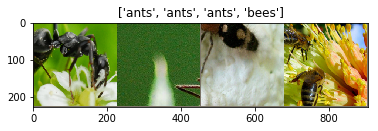

In [7]:
def im_show(input_img, title=None):
    """Img show for Tensor."""
    # Put the channels last. Presumably DataLoader is channels first.
    input_img = input_img.numpy().transpose((1, 2, 0))
    
    # Multiple by the std and add the mean (revert preprocessing)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_img = std * input_img + mean
    
    # Ensure all values are between 0 and 1.
    input_img = np.clip(input_img, 0, 1)

    plt.imshow(input_img)
    if title is not None:
        plt.title(title)

    plt.pause(0.001)
    
inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

im_show(out, title=[class_names[i] for i in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    tic = time.time()
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch} / {num_epochs - 1}')
        print('-' * 10)
        
        # Training phase
        scheduler.step()
        model.train(True)
        
        running_loss = 0.0
        running_corrects = 0
        
        for (inputs, labels) in tqdm(train_dataloader):
            inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            # Run forward prop
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0] * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects / train_size
        
        print(f'Training loss: {epoch_loss} Accuracy: {epoch_acc}')
        
        # Validation phase
        model.train(False)
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in val_dataloader:
            inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            # Run forward prop
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.data[0] * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / val_size
        epoch_acc = running_corrects / val_size
        
        print(f'Validation loss: {epoch_loss} Accuracy: {epoch_acc}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
        
    toc = time.time() - tic
    print('Training complete in {:.0f}m {:.0f}s'.format(toc // 60, toc % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

Load a pretrained model and reset final fully-connected layer.

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)

# Freeze all layers
for param in model_conv.parameters():
    param.requires_grad = False
    
# Replace Dense/FC prediction layer
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(in_features=num_ftrs, out_features=2)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.9)

# Schedule learning rate to decay by a factor of 0.1 every 7 epochs.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_ft = train_model(
    model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 0 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.45it/s]

Training loss: 0.7169160569300417 Accuracy: 0.5245901639344263



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.5532121385624206 Accuracy: 0.7320261437908496

Epoch 1 / 24
----------


100%|██████████| 61/61 [00:25<00:00,  2.41it/s]

Training loss: 0.5729056030023293 Accuracy: 0.7377049180327869



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.4151339332262675 Accuracy: 0.8888888888888888

Epoch 2 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.44it/s]

Training loss: 0.530139934088363 Accuracy: 0.7377049180327869



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.3551463567548328 Accuracy: 0.9019607843137255

Epoch 3 / 24
----------


100%|██████████| 61/61 [00:25<00:00,  2.35it/s]

Training loss: 0.5093536845973281 Accuracy: 0.7827868852459017



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.32034748977695415 Accuracy: 0.9150326797385621

Epoch 4 / 24
----------


100%|██████████| 61/61 [00:29<00:00,  2.06it/s]

Training loss: 0.4435954956246204 Accuracy: 0.8237704918032787



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.2883605537266513 Accuracy: 0.9215686274509803

Epoch 5 / 24
----------


100%|██████████| 61/61 [00:37<00:00,  1.65it/s]

Training loss: 0.4320094018686013 Accuracy: 0.8319672131147541



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.2720385442177455 Accuracy: 0.934640522875817

Epoch 6 / 24
----------


100%|██████████| 61/61 [00:31<00:00,  1.94it/s]

Training loss: 0.47096532192386564 Accuracy: 0.7745901639344263



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.281925361968723 Accuracy: 0.9281045751633987

Epoch 7 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.53it/s]

Training loss: 0.46095535012542227 Accuracy: 0.7663934426229508



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.2732829979432175 Accuracy: 0.9150326797385621

Epoch 8 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.51it/s]

Training loss: 0.4301529976188159 Accuracy: 0.819672131147541



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.2624923727091621 Accuracy: 0.9281045751633987

Epoch 9 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.52it/s]

Training loss: 0.408013717072909 Accuracy: 0.8278688524590164



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.2683043229131917 Accuracy: 0.9281045751633987

Epoch 10 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.49it/s]

Training loss: 0.43632902571412385 Accuracy: 0.8278688524590164



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.24160083514802597 Accuracy: 0.9281045751633987

Epoch 11 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.50it/s]

Training loss: 0.4286073456045057 Accuracy: 0.819672131147541



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.2587296548816893 Accuracy: 0.934640522875817

Epoch 12 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.52it/s]

Training loss: 0.3959776381732988 Accuracy: 0.8319672131147541



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.24959968987341022 Accuracy: 0.934640522875817

Epoch 13 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.49it/s]

Training loss: 0.42482870756114116 Accuracy: 0.7991803278688525



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.25454581991519803 Accuracy: 0.9281045751633987

Epoch 14 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.53it/s]

Training loss: 0.40734676882380344 Accuracy: 0.8237704918032787



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.2442614753164497 Accuracy: 0.934640522875817

Epoch 15 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.53it/s]

Training loss: 0.43215418289430807 Accuracy: 0.8073770491803278



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.2525910982509065 Accuracy: 0.934640522875817

Epoch 16 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.51it/s]

Training loss: 0.40879484314898973 Accuracy: 0.8073770491803278



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.25986472200724037 Accuracy: 0.9215686274509803

Epoch 17 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.52it/s]

Training loss: 0.3904955704681209 Accuracy: 0.8483606557377049



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.24219925687009214 Accuracy: 0.934640522875817

Epoch 18 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.53it/s]

Training loss: 0.4006888090831334 Accuracy: 0.8155737704918032



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.25508836388977524 Accuracy: 0.934640522875817

Epoch 19 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.51it/s]

Training loss: 0.41289400761244727 Accuracy: 0.8278688524590164



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.24383390492765733 Accuracy: 0.9477124183006536

Epoch 20 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.51it/s]

Training loss: 0.4029086139358458 Accuracy: 0.819672131147541



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.2525772940294415 Accuracy: 0.934640522875817

Epoch 21 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.53it/s]

Training loss: 0.4215952873718543 Accuracy: 0.8073770491803278



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.2517247428886252 Accuracy: 0.934640522875817

Epoch 22 / 24
----------


100%|██████████| 61/61 [00:24<00:00,  2.48it/s]

Training loss: 0.39771091522740537 Accuracy: 0.8360655737704918



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.24727884090803806 Accuracy: 0.9477124183006536

Epoch 23 / 24
----------


100%|██████████| 61/61 [00:23<00:00,  2.62it/s]

Training loss: 0.4060430129776236 Accuracy: 0.8319672131147541



  0%|          | 0/61 [00:00<?, ?it/s]

Validation loss: 0.2575480328763233 Accuracy: 0.9215686274509803

Epoch 24 / 24
----------


100%|██████████| 61/61 [00:23<00:00,  2.65it/s]

Training loss: 0.39827045773873565 Accuracy: 0.8401639344262295


Validation loss: 0.2473552558157179 Accuracy: 0.934640522875817

Training complete in 16m 48s
Best validation accuracy: 0.947712
